In [127]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator
#from pcygni_5_Spec_Rel import PcygniCalculator
#from pcygni_profile import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    #plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [128]:
def bin_spectrum(wl, flux, error, mask, binh, weight=False):

    """Bin low S/N 1D data from xshooter
    ----------
    flux : np.array containing 2D-image flux
        Flux in input image
    error : np.array containing 2D-image error
        Error in input image
    binh : int
        binning along x-axis
    Returns
    -------
    binned fits image
    """

    print("Binning image by a factor: "+str(binh))
    if binh == 1:
        return wl, flux, error, mask

    # Outsize
    size = flux.shape[0]
    outsize = int(np.round(size/binh))

    # Containers
    wl_out = np.zeros((outsize))
    res = np.zeros((outsize))
    reserr = np.zeros((outsize))
    resbp = np.zeros((outsize))

    for ii in np.arange(0, size - binh, binh):
        # Find psotions in new array
        h_slice = slice(ii, ii + binh)
        h_index = int((ii + binh)/binh) - 1
        # Construct weighted average and weighted std along binning axis
        res[h_index], reserr[h_index], resbp[h_index] = avg(flux[ii:ii + binh], error[ii:ii + binh], mask = mask[ii:ii + binh], axis=0, weight=weight)
        wl_out[h_index] = np.median(wl[ii:ii + binh], axis=0)

    return wl_out[1:-1], res[1:-1], reserr[1:-1], resbp[1:-1]


def avg(flux, error, mask=None, axis=2, weight=False, weight_map=None):

    """Calculate the weighted average with errors
    ----------
    flux : array-like
        Values to take average of
    error : array-like
        Errors associated with values, assumed to be standard deviations.
    mask : array-like
        Array of bools, where true means a masked value.
    axis : int, default 0
        axis argument passed to numpy
    Returns
    -------
    average, error : tuple
    Notes
    -----
    """
    try:
        if not mask:
            mask = np.zeros_like(flux).astype("bool")
    except:
        pass
        # print("All values are masked... Returning nan")
        # if np.sum(mask.astype("int")) == 0:
        #     return np.nan, np.nan, np.nan


    # Normalize to avoid numerical issues in flux-calibrated data
    norm = abs(np.median(flux[flux > 0]))
    if norm == np.nan or norm == np.inf or norm == 0:
        print("Nomalization factor in avg has got a bad value. It's "+str(norm)+" ... Replacing with 1")

    flux_func = flux.copy() / norm
    error_func = error.copy() / norm

    # Calculate average based on supplied weight map
    if weight_map is not None:

        # Remove non-contributing pixels
        flux_func[mask] = 0
        error_func[mask] = 0
        # https://physics.stackexchange.com/questions/15197/how-do-you-find-the-uncertainty-of-a-weighted-average?newreg=4e2b8a1d87f04c01a82940d234a07fc5
        average = np.sum(flux_func * weight_map, axis = axis) / np.sum(weight_map, axis = axis)
        variance = np.sum(error_func**2 * weight_map**2, axis = axis) / np.sum(weight_map, axis = axis)**2



    # Inverse variance weighted average
    elif weight:
        ma_flux_func = np.ma.array(flux_func, mask=mask)
        ma_error_func = np.ma.array(error_func, mask=mask)
        w = 1.0 / (ma_error_func ** 2.0)
        average = np.ma.sum(ma_flux_func * w, axis = axis) / np.ma.sum(w, axis = axis)
        variance = 1. / np.ma.sum(w, axis = axis)
        if not isinstance(average, float):
            # average[average.mask] = np.nan
            average = average.data
            # variance[variance.mask] = np.nan
            variance = variance.data

    # Normal average
    elif not weight:
        # Number of pixels in the mean
        n = np.sum(np.array(~mask).astype("int"), axis = axis)
        # Remove non-contributing pixels
        flux_func[mask] = 0
        error_func[mask] = 0
        # mean
        average = (1 / n) * np.sum(flux_func, axis = axis)
        # probagate errors
        variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)

    mask = (np.sum((~mask).astype("int"), axis = axis) == 0).astype("int")
    return (average * norm, np.sqrt(variance)*norm, mask)

### Load data 

In [129]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("IntegrationWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import warnings
warnings.filterwarnings("ignore")

In [130]:
OB = 'OB1'

In [131]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = np.sort(os.listdir(path))

x = np.loadtxt(path+'/'+files[0]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & \
            (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
            (~((x[:,0] > 5330) & (x[:,0] < 5740))) & \
            (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
            (x[:,0] > 3300) & (x[:,0] < 22500) #22500
#            (x[:,0] > 3300) & (x[:,0] < 22500) #22500

wl_bin, f_bin, f_err_bin,_             = bin_spectrum(x[:,0], x[:,1], x[:,2], ~exc_reg_2, 20)

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]

error = error #* 2.26

Binning image by a factor: 20


In [132]:
flu = 0.54
n_days = 1.128
nl = 14
tau_r = 0.23 * n_days * 1.083 * nl * flu
tau_r

2.1241598112

In [114]:
flu = 0.54
n_days = 1.128
nl = 14
tau_r = 0.23 * n_days * 1.083 * nl * flu
tau_r * (1.17/1.43)**2

1.4219582207206611

In [115]:
flu = 0.54
n_days = 1.128
nl = 14
tau_r = 0.23 * n_days * 1.083 * nl * flu
tau_r * (1.17/1.43)

# plot t(v) - assume some vphot, ve, tau which describes the decline assume these from an assumed density / mass estimate

1.7379489364363636

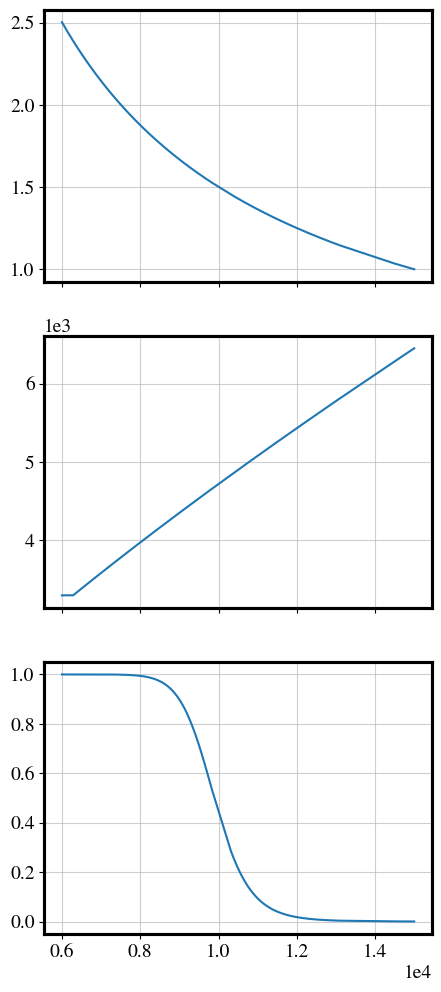

In [133]:
h = 6.626e-34 #SI 4.135e-15
kb = 1.38e-23 #SI
e     = 1.6e-19
eps_0 = 8.85e-12
m_e   = 9.1e-31
c     = 3e8

mu_beta = (10500-wl[(wl>6000) & (wl<15000)])/10500
t_obs = 1.43
t = t_obs/(1-mu_beta) 

T_phys = 4900 * (t/1.43)**(-0.77)
T_phys[T_phys<3300] = 3300
n_e = 1e9 * 1e6

lambda_debroglie = np.sqrt( h**2 / (2*np.pi*m_e * T_phys * kb) )
ni_over_n0 = 2*(lambda_debroglie)**(-3) * 2.01/1.01* np.exp( -5.7/(T_phys*8.61e-5) ) / n_e
rat_1 = (ni_over_n0/(1+ni_over_n0))

nii_over_ni = 2*(lambda_debroglie)**(-3) * 1/2 * np.exp( -11.03/(T_phys*8.61e-5) ) / n_e
rat_2 = (nii_over_ni/(1+nii_over_ni))
    
frac_2nd = ( rat_1*(1-np.array(rat_2)) )

fig, ax = plt.subplots( figsize=(5,12), nrows=3, sharex=True )

ax[0].plot(wl[(wl>6000) & (wl<15000)], t)
ax[1].plot(wl[(wl>6000) & (wl<15000)], T_phys)
ax[2].plot(wl[(wl>6000) & (wl<15000)], frac_2nd)

from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau_arr, lam, vref=0.2, ve=0.2, t0 = 120960): 
    
    y0 = []; y1 = []
    for wl_i, tau in zip(wl, tau_arr):
        prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
        cyg = prof_calc.calc_profile_Flam( npoints=50 )  
        
        inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)  
        #print(inter(wl_i))
        y1.append(inter(wl_i))
    
    #inter = interp1d(cyg[0].value*1e-10, y1, bounds_error=False, fill_value=1)    
    return np.array(y1) #inter(wl)

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=50 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)


#@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    

def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653, tau2 = 0.0, lam2=7000, tau3=0.0, lam3 = 10000, logne=9, 
                    t_crit=1.43): #blackbody

    intensity = temp(wav, T)
    
    
    #pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    #pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    #pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10500,vref=vref, ve=ve , t0=t0)

    #pcyg_prof_novel = p_cygni_line_corr(wav, v_out, v_phot, tau2 , lam2, vref=vref, ve=ve , t0=t0)
    #pcyg_prof_novel2 = p_cygni_line_corr(wav, v_out, v_phot, tau2 , lam2, vref=vref, ve=ve , t0=t0)
    
    
    mu_beta = (10500e-10-wav[(wav>6000e-10) & (wav<15000e-10)])/10830e-10
    t_obs = t_crit
    t = t_obs /(1-mu_beta)

    from scipy.interpolate import interp1d
    time        = np.linspace(0.5, 5.5, 100)
    #tau_in_time = (time/1.43)**2 *tau #
    #tau_in_time = np.ones_like(time)*tau
    #inter_polated_tau = interp1d(time, tau_in_time)

    #tau_in_time_arr = inter_polated_tau(t)

    pcyg_prof3 = p_cygni_line_corr(wav[(wav>6000e-10) & (wav<15000e-10)], v_out, v_phot, tau   , 10830, vref=vref, ve=ve , t0=t0)
#    pcyg_prof3 = p_cygni_line_corr(wav[(wav>6000e-10) & (wav<15000e-10)], v_out, v_phot, tau_in_time_arr   , 10830, vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3#*pcyg_prof4*pcyg_prof5#*pcyg_prof_novel*pcyg_prof_novel2

    #T_phys = 4100 * (t/ (t_obs+9.5/24) )**(-0.54) * (t_obs/t_crit)**(0.54)
    #T_phys[T_phys<3300] = 3300
    #n_e = 10**(logne) * 1e6

    #lambda_debroglie = np.sqrt( h**2 / (2*np.pi*m_e * T_phys * kb) )
    #ni_over_n0 = 2*(lambda_debroglie)**(-3) * 2.01/1.01* np.exp( -5.7/(T_phys*8.61e-5) ) / n_e
    #rat_1 = (ni_over_n0/(1+ni_over_n0))

    #nii_over_ni = 2*(lambda_debroglie)**(-3) * 1/2 * np.exp( -11.03/(T_phys*8.61e-5) ) / n_e
    #rat_2 = (nii_over_ni/(1+nii_over_ni))
    
    #frac_2nd = ( rat_1*(1-np.array(rat_2)) ) 
    

    #print( np.shape(correction), np.shape(intensity), np.shape(intensity[(wav>6000e-10) & (wav<15000e-10)]), correction ) 
    
    #print(T_phys)
    #print(frac_2nd)
    intensity[(wav>6000e-10) & (wav<15000e-10)] = (correction)*intensity[(wav>6000e-10) & (wav<15000e-10)]
        
    #T_phys_n = T * (t/ (t_obs*(1+vphot)) )**(-0.54)
    #flux_ratio = temp(wav[(wav>6000e-10) & (wav<15000e-10)],T_phys_n)/temp(wav[(wav>6000e-10) & (wav<15000e-10)], T)
    #correction[(wav>6000e-10) & (wav<15000e-10)] = 1 + (correction[(wav>6000e-10) & (wav<15000e-10)]-1)*flux_ratio
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    

    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity#*correction
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]
    
    #logne = v["logne"]
    
    t_crit = v["t_crit"]
    #tau2, lam2 = v["tau2"], v["lam2"]
    #tau3, lam3 = v["tau3"], v["lam3"]

    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2,  
                           t_crit=t_crit) #, 
                           #tau2=tau2, lam2=lam2, tau3=tau3, lam3=lam3)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

beta, doppler = np.loadtxt('./codes - Diluted BB/Derivation_conv_Stuart_2.txt')
inter = interp1d(beta, doppler)
c = 3.0e+8
    
def lum_dist_arr(N, vphot, v_perp, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    delta = inter(vphot) #v_perp, 1-2/3*11/10*vphot
    corr = delta#/inter2(vphot)**2#**4
        
    theta = 2*np.sqrt( N*10**(7) / corr ) #inverse
    v = v_perp*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc


n_days = [1.427, 2.417, 3.413, 4.403]

#plt.ylim(-1e-10, 1e-10)

Binning image by a factor: 10


((3300.0, 10000.0), None)

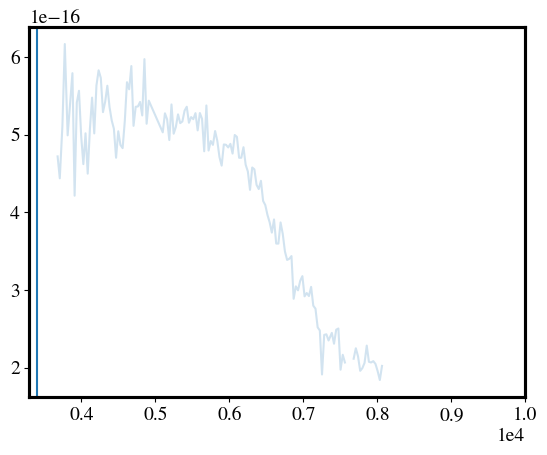

In [134]:
wl_SALT,f_SALT,fe_SALT = np.loadtxt('../Spectral Series (AT2017gfo)/SALT_Crawford.txt').T

exc_reg = (~((wl_SALT > 7550) & (wl_SALT < 7670))) #&  (~((wav > 6800) & (wav < 6950))) 
wl_SALT, f_SALT, fe_SALT,_ = bin_spectrum(wl_SALT, f_SALT, fe_SALT, ~exc_reg, 10)
plt.plot(wl_SALT, f_SALT*10, '-', alpha=0.2)

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.17, min=0, max=2)
p['vmax'].value = 0.40
p['vphot'].value = 0.31
p['ve'].value = 1
p['T'].value = 6300
p['occult'].value = 1
p['tau'].value = 3
#p.add_parameters('logne', 9)
#plt.plot(wli, residual(p, wli*1e-10), color='C2' )

#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)

plt.axvline(2600)
plt.axvline(3400)
#plt.xscale('log')
plt.xlim(3300, 10000), plt.grid()


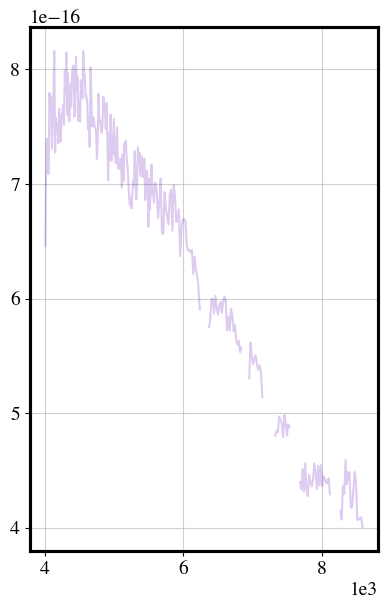

In [135]:
from astropy.io import ascii


def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rtot = rainbow_colors(11)

fig,ax = plt.subplots(figsize=(4.5,6.8))


filename = '../Spectral Series (AT2017gfo)/anufit_spectrum_dered.dat'
t = ascii.read(filename)
# Rename the columns
t.rename_column("col1", "wav"); t.rename_column("col2", "flux")
wav = t['wav'][:-7]; flux = t['flux'][:-7]
    
flux = np.reshape(flux, (int(np.shape(flux)[0]/15), 15) ); wav = np.reshape(wav, (int(np.shape(wav)[0]/15), 15) )
flux_ANU = np.mean(flux,axis=1); wav_ANU = np.mean(wav,axis=1)
exc_reg = (~((wav_ANU > 7550) & (wav_ANU < 7670))) &  (~((wav_ANU > 6850) & (wav_ANU < 6950))) &  (~((wav_ANU > 6250) & (wav_ANU < 6360)))  &  (~((wav_ANU > 7150) & (wav_ANU < 7320))) &  (~((wav_ANU > 8120) & (wav_ANU < 8250))) &  (wav_ANU < 8600) 
wav_ANU[~exc_reg], flux_ANU[~exc_reg] = np.nan, np.nan
plt.plot(wav_ANU, flux_ANU*2e-17, color=get_darker(0.7, rtot[0]), alpha=0.2)


Binning image by a factor: 10


(3800.0, 11000.0)

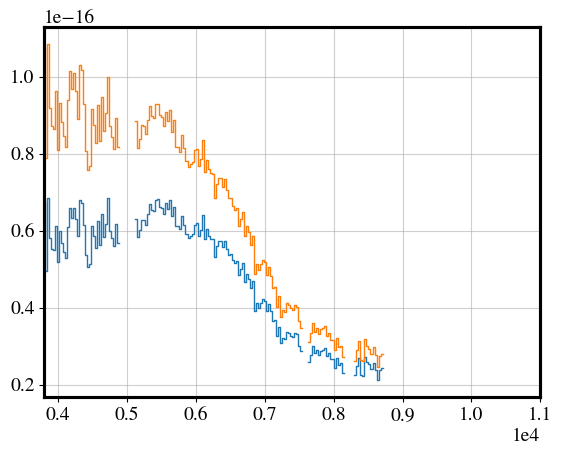

In [136]:
import astropy.io.fits as fits
from dust_extinction.parameter_averages import F04
from extinction import ccm89
import astropy.units as u

ext = F04(Rv=3.1)

#for f in fits.open('../Spectral Series (AT2017gfo)/ligo_oma_clfc2.fits'): 
for f in fits.open('../Spectral Series (AT2017gfo)/ligo_new1_eg21.fits'): 
    head = f.header
    data = f.data

wl_SALT = 2.919*np.arange(len(data))+1574
f_SALT  = data
#exc_reg = (~((wl_SALT > 7550) & (wl_SALT < 7670))) &  (((wl_SALT > 3800) & (wl_SALT < 8700))) 
exc_reg = (~((wl_SALT > 7550) & (wl_SALT < 7670))) &  (~((wl_SALT > 4880) & (wl_SALT < 5135))) &  (~((wl_SALT > 8170) & (wl_SALT < 8320))) & (((wl_SALT > 3800) & (wl_SALT < 8700))) 

wl_SALT,f_SALT,_,_ = bin_spectrum(wl_SALT,f_SALT,np.ones_like(f_SALT), ~exc_reg, 10)
plt.plot( wl_SALT, f_SALT, ds='steps', linewidth=1)

ext = F04(Rv=3.1)
reddening_n = ( ext.extinguish(wl_SALT*u.angstrom, Ebv=0.11))
f_SALT = f_SALT/reddening_n

plt.plot( wl_SALT , f_SALT, ds='steps', linewidth=1)
#plt.ylim(1e-18, 1e-16)
plt.xlim(3800, 11000)


In [120]:
p

name,value,standard error,relative error,initial value,min,max,vary
T,6300.00000,2.46160291,(0.04%),5435.716791746477,2500.00000,7500.00000,True
N,1.3338e-29,3.1434e-32,(0.24%),1.3404076532489784e-29,-inf,inf,True
vphot,0.31000000,6.1103e-04,(0.20%),0.27768223610679355,0.00000000,1.00000000,True
vmax,0.40000000,7.0672e-04,(0.18%),0.34633402047380324,0.00000000,1.00000000,True
t0,126000.000,,,126000,-inf,inf,False
tau,3.00000000,4.75750986,(158.58%),35.43711858345176,0.00000000,100.000000,True
vref,0.00000000,,,0.0,0.00000000,1.00000000,False
ve,1.00000000,0.00663807,(0.66%),0.07449505547902187,0.00000000,1.00000000,True
occult,1.00000000,0.03904019,(3.90%),0.0005456328535526188,0.00000000,2.00000000,True
amp1,0.29438175,0.00724750,(2.46%),0.26169986240919846,0.00000000,5.00000000,True


In [137]:
tau_i = 1
lw = 1

 
#tau0 8.511449673892583 ve 0.10153824315396923
#tau0 14.881208641411925 ve 0.10336911319636276
#tau0 158.74717669948572 ve 0.08320440099158784
#tau0 3823.0115238240032 ve 0.04695527357865939
#tau0 14283.029278754437 ve 0.036604130366884785
#tau0 22246.803792786897 ve 0.032136353482139245

tau_tot = [ 13.8 , 23.8, 287.2, 3823, 14283, 22246 ]
ve_tot  = [ 0.09, 0.09, 0.073, 0.0469, 0.036, 0.0321 ]

Binning image by a factor: 50
Binning image by a factor: 80
Binning image by a factor: 80
Binning image by a factor: 80


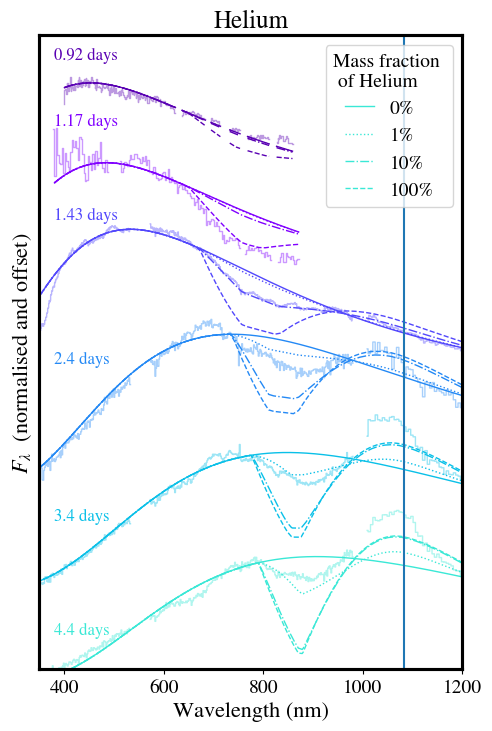

In [148]:
tau_i = 1
lw = 1

tau_tot = [ 13.8 , 23.8, 287.2, 3823, 14283, 22246 ]
ve_tot  = [ 0.09, 0.09, 0.073, 0.0469, 0.036, 0.0321 ]


reset_plt(14, 16)
lw = 1.0
def temp_n(wav,T,N):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return N*a/ ( (wav**5)*(np.exp(b) - 1.0) )


from scipy.optimize import curve_fit
p_ANU,_ = curve_fit(temp_n, wav_ANU[flux_ANU==flux_ANU]*1e-10, flux_ANU[flux_ANU==flux_ANU], p0=[6000, 1e-29*1e16])

p_SALT,_ = curve_fit(temp_n, wl_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)]*1e-10, f_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)], p0=[6000, 1e-29])


from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


#fig, ax2 = plt.subplots( figsize=(11,6), ncols=2 )
#ax = ax2[0]
#axins = ax2[1]

off_sets = np.linspace(-0.2,2.1,5)[::-1]

fig,axi = plt.subplot_mosaic("A", figsize=(5.2,7.6) )
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax = axi['A']
ratio_off_set = np.linspace(0,3.8,8)[::-1]

# ANU
norm = np.max(flux_ANU[flux_ANU==flux_ANU])
ax.plot(wav_ANU/10 , 0.75*flux_ANU/norm+ratio_off_set[2], 
             color=get_darker(0.7, rtot[0]), ds='steps', alpha=0.4, linewidth=1)#, label='0.92 days', alpha=0.4, linewidth=1)

ax.text(3800/10, ratio_off_set[2]+0.85 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '0.92 days', color=get_darker(0.7, rtot[0]), fontsize=fontsize, rotation=rotation)
#ax.plot(    wav_ANU/10, 0.8*temp_n(wav_ANU*1e-10, *p_ANU )/norm+ratio_off_set[2], 
#            color=get_darker(0.7, rtot[0]), linewidth=1, ls='--' )


pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.17, min=0, max=2)
p['vmax'].value = 0.40
p['vphot'].value = 0.31
p['T'].value = 6400
p['occult'].value = 1

p['tau'].max = tau_tot[0]*tau_i/50; 
p['tau'].value = tau_tot[0]*tau_i/50; 
p['ve'].value = ve_tot[0]; 
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='dotted', linewidth=lw )


p['tau'].max = tau_tot[0]*tau_i/5; 
p['tau'].value = tau_tot[0]*tau_i/5; 
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='-.', linewidth=lw )

p['tau'].max = tau_tot[0]*tau_i*2; 
p['tau'].value = tau_tot[0]*tau_i*2; 
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='--', linewidth=lw )


p['tau'].value = 0
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='-', linewidth=lw )



# SALT
ax.plot(wl_SALT/10 , f_SALT/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
             color=get_darker(1, rtot[0]), ds='steps', alpha=0.4, linewidth=1)#, label='1.17 days', alpha=0.4, linewidth=1)
#pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
pickle_in = open('../Kilonova/data/Early_Chains/SALT_27dec_params.pkl',"rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.17, min=0, max=2)
p['vmax'].value = 0.40
p['vphot'].value = 0.31
p['ve'].value = 1
#p['T'].value = 6300
p['occult'].value = 1
p['tau'].value = tau_i

p['vmax'].value = 0.40
p['vphot'].value = 0.29 #35
p['ve'].value = 1
#p['T'].value = 6000
p['occult'].value = 1
p['tau'].value = tau_i

p['vmax'].value = 0.40
p['vphot'].value = 0.30#p['T'].value = 6300
p['tau'].max = tau_tot[1]*tau_i/50; 
p['tau'].value = tau_tot[1]*tau_i/50; 
p['ve'].value = 0.09;

ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='dotted' )


p['tau'].max = tau_tot[1]*tau_i/5; 
p['tau'].value = tau_tot[1]*tau_i/5; 
p['ve'].value = 0.09;

ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='-.' )

p['vmax'].value = 0.40
p['vphot'].value = 0.30#p['T'].value = 6300
p['tau'].max = tau_tot[1]*tau_i*2; 
p['tau'].value = tau_tot[1]*tau_i*2; 
p['ve'].value = 0.09;

ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='--' )


p['tau'].value=0
ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='-' )



# Days
ax.text(3800/10, ratio_off_set[3]+1.02 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.17 days', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[4]+1.03 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.43 days', color=r[0], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[5]+0.75 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '2.4 days', color=r[1], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[6]+0.4 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '3.4 days', color=r[2], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[7]+0.3 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '4.4 days', color=r[3], fontsize=fontsize, rotation=rotation)

# X-shooter
for i in [0,1,2,3]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19300))
    
    if (i == 0): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 50)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        
        pickle_in = open('./data/OB1/OB1_3_peaks_with_gaussian_3.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['tau'].value = tau_i
        
        p1['vmax'].value = 0.38
        p1['vphot'].value = 0.30
        p1['tau'].max = tau_tot[2]*tau_i/50; 
        p1['tau'].value = tau_tot[2]*tau_i/50; 
        p1['ve'].value = ve_tot[2]; 
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted' )
        
        p1['tau'].max = tau_tot[2]*tau_i/5; 
        p1['tau'].value = tau_tot[2]*tau_i/5; 
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.' )
        
        p1['tau'].max = tau_tot[2]*tau_i*2; 
        p1['tau'].value = tau_tot[2]*tau_i*2; 
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-' )
        
    if (i==1): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB2/OB2_3_peaks_with_gaussian_1.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        
        p1['vmax'].value = 0.32
        p1['vphot'].value = 0.25
        p1['tau'].max = tau_tot[3]*tau_i/50; 
        p1['tau'].value = tau_tot[3]*tau_i/50; 
        p1['ve'].value = ve_tot[3];  

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted' )
        
        p1['tau'].max = tau_tot[3]*tau_i/5; 
        p1['tau'].value = tau_tot[3]*tau_i/5; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.' )
        
        p1['tau'].max = tau_tot[3]*tau_i*2; 
        p1['tau'].value = tau_tot[3]*tau_i*2; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        # p1['vmax'].value = 0.31
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-' )
        
        
    if (i==2): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB3/OB3_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        
        
        p1['vmax'].value = 0.283
        p1['vphot'].value = 0.21
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        #p1['vmax'].value = 0.26
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-' )
        

        p1['tau'].max = tau_tot[4]*tau_i/50; 
        p1['tau'].value = tau_tot[4]*tau_i/50; 
        p1['ve'].value = ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted' )
        
        p1['tau'].max = tau_tot[4]*tau_i/5; 
        p1['tau'].value = tau_tot[4]*tau_i/5; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.' )
        
        p1['tau'].max = tau_tot[4]*tau_i*2; 
        p1['tau'].value = tau_tot[4]*tau_i*2; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--' )
        
    if (i==3): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB4/OB4_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        
        
        p1['N'].value = 1.08*p1['N'].value
        p1['T'].value = 0.99*p1['T'].value
        p1['vmax'].value = 0.270
        p1['vphot'].value = 0.19
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        #p1['vmax'].value = 0.26
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-', label = '0%' )
        

        p1['tau'].max = tau_tot[4]*tau_i/50; 
        p1['tau'].value = tau_tot[4]*tau_i/50; 
        p1['ve'].value = ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted', label = '1%' )
        
        p1['tau'].max = tau_tot[4]*tau_i/5; 
        p1['tau'].value = tau_tot[4]*tau_i/5; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.', label = '10%' )
        
        p1['tau'].max = tau_tot[4]*tau_i*2; 
        p1['tau'].value = tau_tot[4]*tau_i*2; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--', label = '100%' )
        
        p1['ve'].value = 1; 
        p1['tau'].max = 1; 
        p1['tau'].value = 1; 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color=get_darker(1, r[i]), linewidth=lw, ls='--', label = '100%' )
        
        
    
    
ax.set_xlim(350, 1200)#, 
ax.set_ylim(0.1, 3.7)
ax.set_yticks([])
ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength (nm)', fontsize=16)
#plt.yscale('log')
plt.rcParams['legend.title_fontsize'] = 14
plt.legend(frameon=True, fontsize=14, handlelength=1.5, title='Mass fraction \n of Helium')
plt.title('Helium', fontsize=18)

import matplotlib.ticker as mticker
ax.set_ylabel(r'$F_{\lambda}$  (normalised and offset)', fontsize=16)
plt.tight_layout() 

plt.axvline(1083.3, ls='-', alpha=1)

#plt.axvline(930)
#plt.axvline(945)
#plt.axvline(960)
#plt.axvline(980)

#axins.axvline(1045, color='k', alpha=0.3)
#plt.savefig('Pictures/He_feature_emergence_Comparison_with_Sr_4days_smaller_font.png', dpi=300)
#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.pdf', dpi=300)

Binning image by a factor: 50
Binning image by a factor: 80
0.047
Binning image by a factor: 80
Binning image by a factor: 80


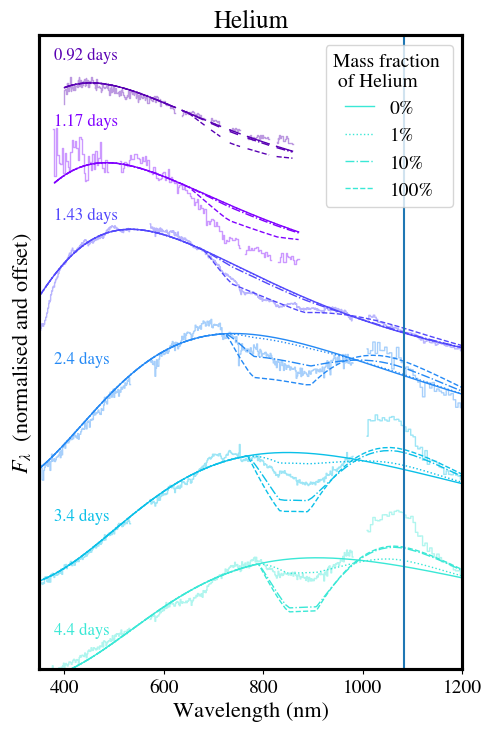

In [227]:
tau_i = 1
lw = 1

#tau_tot = [ 13.8 , 23.8, 287.2, 3823, 14283, 22246 ]
#ve_tot  = [ 0.09, 0.09, 0.073, 0.0469, 0.036, 0.0321 ]

tau_tot = [ 22.25 , 32.58, 30, 4790.17, 33293, 65289 ]
ve_tot  = [ 0.0977, 0.0978, 0.1039, 0.0470, 0.03496, 0.0303892 ]


reset_plt(14, 16)
lw = 1.0
def temp_n(wav,T,N):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return N*a/ ( (wav**5)*(np.exp(b) - 1.0) )


from scipy.optimize import curve_fit
p_ANU,_ = curve_fit(temp_n, wav_ANU[flux_ANU==flux_ANU]*1e-10, flux_ANU[flux_ANU==flux_ANU], p0=[6000, 1e-29*1e16])

p_SALT,_ = curve_fit(temp_n, wl_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)]*1e-10, f_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)], p0=[6000, 1e-29])


from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


#fig, ax2 = plt.subplots( figsize=(11,6), ncols=2 )
#ax = ax2[0]
#axins = ax2[1]

off_sets = np.linspace(-0.2,2.1,5)[::-1]

fig,axi = plt.subplot_mosaic("A", figsize=(5.2,7.6) )
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax = axi['A']
ratio_off_set = np.linspace(0,3.8,8)[::-1]

# ANU
norm = np.max(flux_ANU[flux_ANU==flux_ANU])
ax.plot(wav_ANU/10 , 0.75*flux_ANU/norm+ratio_off_set[2], 
             color=get_darker(0.7, rtot[0]), ds='steps', alpha=0.4, linewidth=1)#, label='0.92 days', alpha=0.4, linewidth=1)

ax.text(3800/10, ratio_off_set[2]+0.85 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '0.92 days', color=get_darker(0.7, rtot[0]), fontsize=fontsize, rotation=rotation)
#ax.plot(    wav_ANU/10, 0.8*temp_n(wav_ANU*1e-10, *p_ANU )/norm+ratio_off_set[2], 
#            color=get_darker(0.7, rtot[0]), linewidth=1, ls='--' )


pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.17, min=0, max=2)
p['vmax'].value = 0.40
p['vphot'].value = 0.32
p['T'].value = 6400
p['occult'].value = 1

p['tau'].max = tau_tot[0]*tau_i/100; 
p['tau'].value = tau_tot[0]*tau_i/100; 
p['ve'].value = ve_tot[0]; 
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='dotted', linewidth=lw )


p['tau'].max = tau_tot[0]*tau_i/10; 
p['tau'].value = tau_tot[0]*tau_i/10; 
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='-.', linewidth=lw )

p['tau'].max = tau_tot[0]*tau_i; 
p['tau'].value = tau_tot[0]*tau_i; 
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='--', linewidth=lw )


p['tau'].value = 0
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='-', linewidth=lw )



# SALT
ax.plot(wl_SALT/10 , f_SALT/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
             color=get_darker(1, rtot[0]), ds='steps', alpha=0.4, linewidth=1)#, label='1.17 days', alpha=0.4, linewidth=1)
#pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
pickle_in = open('../Kilonova/data/Early_Chains/SALT_27dec_params.pkl',"rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.17, min=0, max=2)
p['vmax'].value = 0.40
p['vphot'].value = 0.31
p['ve'].value = 1
#p['T'].value = 6300
p['occult'].value = 1
p['tau'].value = tau_i

p['vmax'].value = 0.40
p['vphot'].value = 0.29 #35
p['ve'].value = 1
#p['T'].value = 6000
p['occult'].value = 1
p['tau'].value = tau_i

p['vmax'].value = 0.40
p['vphot'].value = 0.325#p['T'].value = 6300
p['tau'].max = tau_tot[1]*tau_i/100; 
p['tau'].value = tau_tot[1]*tau_i/100; 
p['ve'].value = 0.09;

ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='dotted' )


p['tau'].max = tau_tot[1]*tau_i/10; 
p['tau'].value = tau_tot[1]*tau_i/10; 
p['ve'].value = 0.09;

ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='-.' )

p['vmax'].value = 0.40
#p['vphot'].value = 0.31#p['T'].value = 6300
p['tau'].max = tau_tot[1]*tau_i; 
p['tau'].value = tau_tot[1]*tau_i; 
p['ve'].value = 0.09;

ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='--' )


p['tau'].value=0
ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='-' )



# Days
ax.text(3800/10, ratio_off_set[3]+1.02 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.17 days', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[4]+1.03 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.43 days', color=r[0], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[5]+0.75 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '2.4 days', color=r[1], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[6]+0.4 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '3.4 days', color=r[2], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[7]+0.3 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '4.4 days', color=r[3], fontsize=fontsize, rotation=rotation)

# X-shooter
for i in [0,1,2,3]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19300))
    
    if (i == 0): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 50)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        
        pickle_in = open('./data/OB1/OB1_3_peaks_with_gaussian_3.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['tau'].value = tau_i
        
        p1['vmax'].value = 0.37
        p1['vphot'].value = 0.32
        p1['tau'].max = tau_tot[2]*tau_i/100; 
        p1['tau'].value = tau_tot[2]*tau_i/100; 
        p1['ve'].value = ve_tot[2]; 
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted' )
        
        p1['tau'].max = tau_tot[2]*tau_i/10; 
        p1['tau'].value = tau_tot[2]*tau_i/10; 
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.' )
        
        p1['tau'].max = tau_tot[2]*tau_i; 
        p1['tau'].value = tau_tot[2]*tau_i; 
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-' )
        
    if (i==1): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB2/OB2_3_peaks_with_gaussian_1.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        
        p1['T'].value = 0.995*p1['T'].value
        p1['N'].value = 1.03*p1['N'].value
        
        p1['vmax'].value = 0.33
        p1['vphot'].value = 0.28
        p1['tau'].max = tau_tot[3]*tau_i/100; 
        p1['tau'].value = tau_tot[3]*tau_i/100; 
        p1['ve'].value = ve_tot[3];  
        print(p1['ve'].value)

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted' )
        
        p1['tau'].max = tau_tot[3]*tau_i/10; 
        p1['tau'].value = tau_tot[3]*tau_i/10; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.' )
        
        p1['tau'].max = tau_tot[3]*tau_i; 
        p1['tau'].value = tau_tot[3]*tau_i; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        # p1['vmax'].value = 0.31
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-' )
        
        
    if (i==2): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB3/OB3_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        
        
        p1['vmax'].value = 0.29
        p1['vphot'].value = 0.23
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        #p1['vmax'].value = 0.26
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-' )
        

        p1['tau'].max = tau_tot[4]*tau_i/100; 
        p1['tau'].value = tau_tot[4]*tau_i/100; 
        p1['ve'].value = ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted' )
        
        p1['tau'].max = tau_tot[4]*tau_i/10; 
        p1['tau'].value = tau_tot[4]*tau_i/10; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.' )
        
        p1['tau'].max = tau_tot[4]*tau_i; 
        p1['tau'].value = tau_tot[4]*tau_i; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--' )
        
    if (i==3): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB4/OB4_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        
        
        p1['N'].value = 1.07*p1['N'].value
        p1['T'].value = 0.99*p1['T'].value
        p1['vmax'].value = 0.27
        p1['vphot'].value = 0.215
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        #p1['vmax'].value = 0.26
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-', label = '0%' )
        

        p1['tau'].max = tau_tot[4]*tau_i/100; 
        p1['tau'].value = tau_tot[4]*tau_i/100; 
        p1['ve'].value = ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted', label = '1%' )
        
        p1['tau'].max = tau_tot[4]*tau_i/10; 
        p1['tau'].value = tau_tot[4]*tau_i/10; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.', label = '10%' )
        
        p1['tau'].max = tau_tot[4]*tau_i; 
        p1['tau'].value = tau_tot[4]*tau_i; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--', label = '100%' )
        
        p1['ve'].value = 1; 
        p1['tau'].max = 1; 
        p1['tau'].value = 1; 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color=get_darker(1, r[i]), linewidth=lw, ls='--', label = '100%' )
        
        
    
    
ax.set_xlim(350, 1200)#, 
ax.set_ylim(0.1, 3.7)
ax.set_yticks([])
ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength (nm)', fontsize=16)
#plt.yscale('log')
plt.rcParams['legend.title_fontsize'] = 14
plt.legend(frameon=True, fontsize=14, handlelength=1.5, title='Mass fraction \n of Helium')
plt.title('Helium', fontsize=18)

import matplotlib.ticker as mticker
ax.set_ylabel(r'$F_{\lambda}$  (normalised and offset)', fontsize=16)
plt.tight_layout() 

plt.axvline(1083.3, ls='-', alpha=1)

#plt.axvline(930)
#plt.axvline(945)
#plt.axvline(960)
#plt.axvline(980)

#axins.axvline(1045, color='k', alpha=0.3)
plt.savefig('Pictures/He_feature_emergence_Comparison_with_Sr_4days_smaller_font_22sep.png', dpi=300)
#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.pdf', dpi=300)

In [189]:
tau_tot[4]*tau_i*0.01 * np.exp(-0.27/ve_tot[4])

0.14731533252433154

In [210]:
#780/1083


In [123]:
### Spec Rel

Binning image by a factor: 50
Binning image by a factor: 80
Binning image by a factor: 80
Binning image by a factor: 80


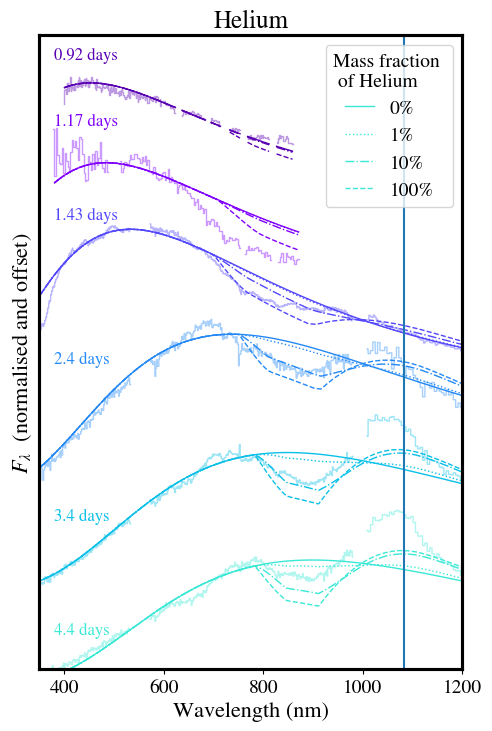

In [126]:
tau_i = 1
lw = 1

tau_tot = [ 13.8 , 23.8, 287.2, 3823, 14283, 22246 ]
ve_tot  = [ 0.09, 0.09, 0.073, 0.0469, 0.036, 0.0321 ]


reset_plt(14, 16)
lw = 1.0
def temp_n(wav,T,N):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return N*a/ ( (wav**5)*(np.exp(b) - 1.0) )


from scipy.optimize import curve_fit
p_ANU,_ = curve_fit(temp_n, wav_ANU[flux_ANU==flux_ANU]*1e-10, flux_ANU[flux_ANU==flux_ANU], p0=[6000, 1e-29*1e16])

p_SALT,_ = curve_fit(temp_n, wl_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)]*1e-10, f_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)], p0=[6000, 1e-29])


from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


#fig, ax2 = plt.subplots( figsize=(11,6), ncols=2 )
#ax = ax2[0]
#axins = ax2[1]

off_sets = np.linspace(-0.2,2.1,5)[::-1]

fig,axi = plt.subplot_mosaic("A", figsize=(5.2,7.6) )
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax = axi['A']
ratio_off_set = np.linspace(0,3.8,8)[::-1]

# ANU
norm = np.max(flux_ANU[flux_ANU==flux_ANU])
ax.plot(wav_ANU/10 , 0.75*flux_ANU/norm+ratio_off_set[2], 
             color=get_darker(0.7, rtot[0]), ds='steps', alpha=0.4, linewidth=1)#, label='0.92 days', alpha=0.4, linewidth=1)

ax.text(3800/10, ratio_off_set[2]+0.85 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '0.92 days', color=get_darker(0.7, rtot[0]), fontsize=fontsize, rotation=rotation)
#ax.plot(    wav_ANU/10, 0.8*temp_n(wav_ANU*1e-10, *p_ANU )/norm+ratio_off_set[2], 
#            color=get_darker(0.7, rtot[0]), linewidth=1, ls='--' )


pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.17, min=0, max=2)
p['vmax'].value = 0.40
p['vphot'].value = 0.31
p['T'].value = 6400
p['occult'].value = 1

p['tau'].max = tau_tot[0]*tau_i/50; 
p['tau'].value = tau_tot[0]*tau_i/50; 
p['ve'].value = ve_tot[0]; 
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='dotted', linewidth=lw )


p['tau'].max = tau_tot[0]*tau_i/5; 
p['tau'].value = tau_tot[0]*tau_i/5; 
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='-.', linewidth=lw )

p['tau'].max = tau_tot[0]*tau_i*2; 
p['tau'].value = tau_tot[0]*tau_i*2; 
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='--', linewidth=lw )


p['tau'].value = 0
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='-', linewidth=lw )



# SALT
ax.plot(wl_SALT/10 , f_SALT/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
             color=get_darker(1, rtot[0]), ds='steps', alpha=0.4, linewidth=1)#, label='1.17 days', alpha=0.4, linewidth=1)
#pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
pickle_in = open('../Kilonova/data/Early_Chains/SALT_27dec_params.pkl',"rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.17, min=0, max=2)
p['vmax'].value = 0.40
p['vphot'].value = 0.31
p['ve'].value = 1
#p['T'].value = 6300
p['occult'].value = 1
p['tau'].value = tau_i

p['vmax'].value = 0.40
p['vphot'].value = 0.29 #35
p['ve'].value = 1
#p['T'].value = 6000
p['occult'].value = 1
p['tau'].value = tau_i

p['vmax'].value = 0.40
p['vphot'].value = 0.30#p['T'].value = 6300
p['tau'].max = tau_tot[1]*tau_i/50; 
p['tau'].value = tau_tot[1]*tau_i/50; 
p['ve'].value = 0.09;

ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='dotted' )


p['tau'].max = tau_tot[1]*tau_i/5; 
p['tau'].value = tau_tot[1]*tau_i/5; 
p['ve'].value = 0.09;

ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='-.' )

p['vmax'].value = 0.40
p['vphot'].value = 0.30#p['T'].value = 6300
p['tau'].max = tau_tot[1]*tau_i*2; 
p['tau'].value = tau_tot[1]*tau_i*2; 
p['ve'].value = 0.09;

ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='--' )


p['tau'].value=0
ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='-' )



# Days
ax.text(3800/10, ratio_off_set[3]+1.02 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.17 days', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[4]+1.03 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.43 days', color=r[0], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[5]+0.75 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '2.4 days', color=r[1], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[6]+0.4 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '3.4 days', color=r[2], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[7]+0.3 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '4.4 days', color=r[3], fontsize=fontsize, rotation=rotation)

# X-shooter
for i in [0,1,2,3]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19300))
    
    if (i == 0): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 50)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        
        pickle_in = open('./data/OB1/OB1_3_peaks_with_gaussian_3.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['tau'].value = tau_i
        
        p1['vmax'].value = 0.38 + 0.03
        p1['vphot'].value = 0.30 + 0.03
        p1['tau'].max = tau_tot[2]*tau_i/50; 
        p1['tau'].value = tau_tot[2]*tau_i/50; 
        p1['ve'].value = ve_tot[2]; 
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted' )
        
        p1['tau'].max = tau_tot[2]*tau_i/5; 
        p1['tau'].value = tau_tot[2]*tau_i/5; 
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.' )
        
        p1['tau'].max = tau_tot[2]*tau_i*2; 
        p1['tau'].value = tau_tot[2]*tau_i*2; 
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-' )
        
    if (i==1): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB2/OB2_3_peaks_with_gaussian_1.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        
        p1['vmax'].value = 0.32 + 0.03
        p1['vphot'].value = 0.25 + 0.03
        p1['tau'].max = tau_tot[3]*tau_i/50; 
        p1['tau'].value = tau_tot[3]*tau_i/50; 
        p1['ve'].value = ve_tot[3];  

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted' )
        
        p1['tau'].max = tau_tot[3]*tau_i/5; 
        p1['tau'].value = tau_tot[3]*tau_i/5; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.' )
        
        p1['tau'].max = tau_tot[3]*tau_i*2; 
        p1['tau'].value = tau_tot[3]*tau_i*2; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        # p1['vmax'].value = 0.31
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-' )
        
        
    if (i==2): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB3/OB3_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        
        
        p1['vmax'].value = 0.283 + 0.03
        p1['vphot'].value = 0.21 + 0.03
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        #p1['vmax'].value = 0.26
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-' )
        

        p1['tau'].max = tau_tot[4]*tau_i/50; 
        p1['tau'].value = tau_tot[4]*tau_i/50; 
        p1['ve'].value = ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted' )
        
        p1['tau'].max = tau_tot[4]*tau_i/5; 
        p1['tau'].value = tau_tot[4]*tau_i/5; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.' )
        
        p1['tau'].max = tau_tot[4]*tau_i*2; 
        p1['tau'].value = tau_tot[4]*tau_i*2; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--' )
        
    if (i==3): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB4/OB4_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        
        
        p1['vmax'].value = 0.283 + 0.03
        p1['vphot'].value = 0.21 + 0.03
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        #p1['vmax'].value = 0.26
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-', label = '0%' )
        

        p1['tau'].max = tau_tot[4]*tau_i/50; 
        p1['tau'].value = tau_tot[4]*tau_i/50; 
        p1['ve'].value = ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted', label = '1%' )
        
        p1['tau'].max = tau_tot[4]*tau_i/5; 
        p1['tau'].value = tau_tot[4]*tau_i/5; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.', label = '10%' )
        
        p1['tau'].max = tau_tot[4]*tau_i*2; 
        p1['tau'].value = tau_tot[4]*tau_i*2; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--', label = '100%' )
        
        p1['ve'].value = 1; 
        p1['tau'].max = 1; 
        p1['tau'].value = 1; 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color=get_darker(1, r[i]), linewidth=lw, ls='--', label = '100%' )
        
        
    
    
ax.set_xlim(350, 1200)#, 
ax.set_ylim(0.1, 3.7)
ax.set_yticks([])
ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength (nm)', fontsize=16)
#plt.yscale('log')
plt.rcParams['legend.title_fontsize'] = 14
plt.legend(frameon=True, fontsize=14, handlelength=1.5, title='Mass fraction \n of Helium')
plt.title('Helium', fontsize=18)

import matplotlib.ticker as mticker
ax.set_ylabel(r'$F_{\lambda}$  (normalised and offset)', fontsize=16)
plt.tight_layout() 

plt.axvline(1083.3, ls='-', alpha=1)

#plt.axvline(930)
#plt.axvline(945)
#plt.axvline(960)
#plt.axvline(980)

#axins.axvline(1045, color='k', alpha=0.3)
#plt.savefig('Pictures/He_feature_emergence_Comparison_with_Sr_4days_smaller_font.png', dpi=300)
#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.pdf', dpi=300)

In [228]:
790/1083

0.7294552169898431

(array(0.3059771), -0.12153877525742096)

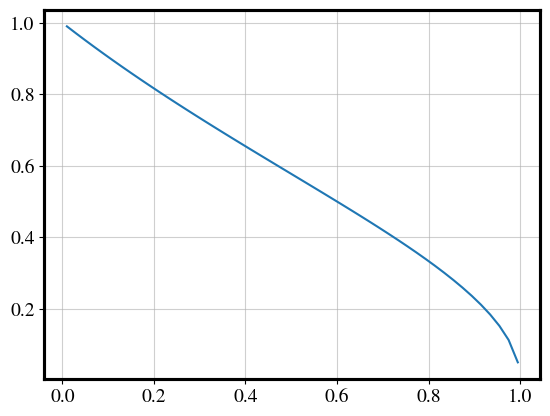

In [229]:
delta = 0.729
v = np.linspace(0.01, 0.995)
delta_arr = (1/(1+v)*np.sqrt(1-v**2))

plt.plot(v, delta_arr)
interp1d(delta_arr, v)(delta), delta**2-1/(delta**2+1)

In [97]:
import numpy as np
import scipy.interpolate as interp

# Speed of light in m/s
#c = 1  

# Define a range of velocities (in m/s)
velocities = np.linspace(0, 0.99 * c, 10000)  # Velocities from 0 to 99% the speed of light

# Calculate corresponding Doppler corrections for those velocities
doppler_corrections = np.sqrt((1 - velocities/c) / (1 + velocities/c))
#doppler_corrections = np.sqrt(1-velocities**2)/(1+velocities) #np.sqrt((1 + velocities/c) / (1 - velocities/c))
#doppler_corrections = 1/(1-velocities)                        #np.sqrt((1 + velocities/c) / (1 - velocities/c))

# Use scipy.interpolate to create an interpolation function
interp_func = interp.interp1d(doppler_corrections, velocities, kind='linear', fill_value="extrapolate")

# Now, given a Doppler correction (delta), find the corresponding velocity
def velocity_from_doppler(delta):
    return interp_func(delta)

# Example usage:
for doppler in [0.6, 0.63, 0.665, 0.69, 0.72]: 
    doppler_shift = (doppler)**(1) #1300/1000 #1.2  # Replace with your value of delta
    velocity = velocity_from_doppler(doppler_shift)
    print(f"The velocity corresponding to a Doppler correction of {doppler_shift} is {velocity/c:.4f} c.")


The velocity corresponding to a Doppler correction of 0.6 is 0.4706 c.
The velocity corresponding to a Doppler correction of 0.63 is 0.4317 c.
The velocity corresponding to a Doppler correction of 0.665 is 0.3867 c.
The velocity corresponding to a Doppler correction of 0.69 is 0.3549 c.
The velocity corresponding to a Doppler correction of 0.72 is 0.3172 c.


In [153]:
# Example usage:
for doppler in [880/1083, 930/1083, 945/1083, 960/1083, 980/1083]: 
    doppler_shift = (doppler)**(1) #1300/1000 #1.2  # Replace with your value of delta
    velocity = velocity_from_doppler(doppler_shift)
    print(f"The velocity corresponding to a Doppler correction of {doppler_shift} is {velocity/c:.4f} c.")



The velocity corresponding to a Doppler correction of 0.8125577100646353 is 0.2046 c.
The velocity corresponding to a Doppler correction of 0.8587257617728532 is 0.1511 c.
The velocity corresponding to a Doppler correction of 0.8725761772853186 is 0.1355 c.
The velocity corresponding to a Doppler correction of 0.8864265927977839 is 0.1200 c.
The velocity corresponding to a Doppler correction of 0.9048938134810711 is 0.0996 c.


In [96]:
650/1083, 680/1083, 720/1083, 750/1083, 790/1083

(0.6001846722068329,
 0.6278855032317636,
 0.6648199445983379,
 0.6925207756232687,
 0.7294552169898431)

In [154]:
1-650/1083, 1-680/1083, 1-720/1083, 1-750/1083, 1-790/1083

(0.3998153277931671,
 0.3721144967682364,
 0.33518005540166207,
 0.30747922437673125,
 0.27054478301015694)

In [156]:
(1-0.4)

0.6

In [149]:
900/1083

0.8310249307479224

i=3
Binning image by a factor: 20


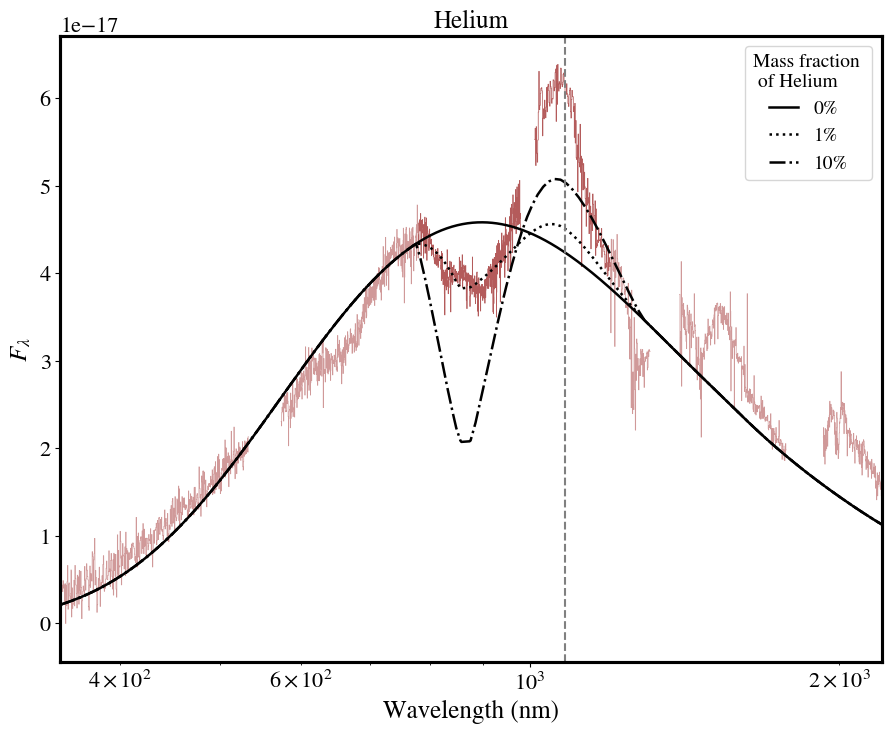

In [20]:
reset_plt(16, 16)

def temp_n(wav,T,N):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return N*a/ ( (wav**5)*(np.exp(b) - 1.0) )


from scipy.optimize import curve_fit
p_ANU,_ = curve_fit(temp_n, wav_ANU[flux_ANU==flux_ANU]*1e-10, flux_ANU[flux_ANU==flux_ANU], p0=[6000, 1e-29*1e16])

p_SALT,_ = curve_fit(temp_n, wl_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)]*1e-10, f_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)], p0=[6000, 1e-29])


from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


#fig, ax2 = plt.subplots( figsize=(11,6), ncols=2 )
#ax = ax2[0]
#axins = ax2[1]

off_sets = np.linspace(-0.2,2.1,5)[::-1]

fig,axi = plt.subplot_mosaic("A", figsize=(9.2,7.6) )
ax = axi['A']

#X-shooter
for i in [3]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13100) & (wl < 14000)) | ((wl > 13300) & (wl < 14000)) | ((wl > 17750) & (wl < 19300))
    
    
    if (i==3): 
        print('i=3')
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 20)

        ax.plot(wl50/10, flux50,#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color='darkred' , alpha=0.4, ds='steps', linewidth=0.5)#, label=str(i+1.4)+' days', linewidth=1)
        
        ax.plot(wl50[(wl50>7800) & (wl50<12000)]/10, flux50[(wl50>7800) & (wl50<12000)],#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color='darkred' , alpha=0.4, ds='steps', linewidth=0.5)
        
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB4/OB4_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        
        lw=1.8
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        
        
        p1['vmax'].value = 0.283
        p1['vphot'].value = 0.21
        p1['N'].value = 3.2e-29
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        #p1['vmax'].value = 0.26
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='-', label = '0%' )
        

        p1['tau'].max = tau_tot[4]*tau_i/50; 
        p1['tau'].value = tau_tot[4]*tau_i/50; 
        p1['ve'].value = ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='dotted', label = '1%' )
        
        p1['tau'].max = tau_tot[4]*tau_i/5; 
        p1['tau'].value = tau_tot[4]*tau_i/5; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='-.', label = '10%' )
        
        p1['tau'].max = tau_tot[4]*tau_i*2; 
        p1['tau'].value = tau_tot[4]*tau_i*2; 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color='k', linewidth=lw, ls='--', label = '100%' )
        
        p1['ve'].value = 1; 
        p1['tau'].max = 1; 
        p1['tau'].value = 1; 

    
    
ax.set_xlim(350, 2200)#, 
#ax.set_ylim(0.1, 3.7)
#ax.set_yticks([])
ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength (nm)', fontsize=18)
#plt.yscale('log')
plt.rcParams['legend.title_fontsize'] = 14
plt.legend(frameon=True, fontsize=14, handlelength=1.5, title='Mass fraction \n of Helium')
plt.title('Helium', fontsize=18)

import matplotlib.ticker as mticker
ax.set_ylabel(r'$F_{\lambda}$', fontsize=18)
plt.tight_layout()

plt.axvline(1083.3, ls='--', alpha=1, color='grey')
plt.xscale('log')
#axins.axvline(1045, color='k', alpha=0.3)
#plt.savefig('Pictures/He_feature_emergence_Comparison_with_Sr_4days.png', dpi=300)
#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.pdf', dpi=300)

Binning image by a factor: 50
Binning image by a factor: 50
Binning image by a factor: 80


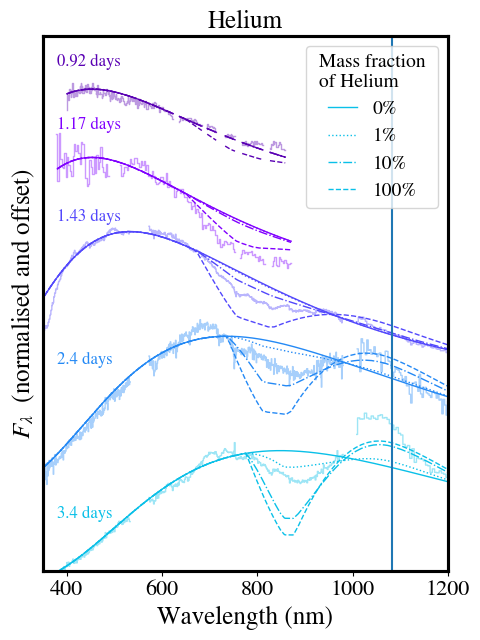

In [31]:
tau_1 = 0.019964504272106;  ve1 =  0.09006458010920136
tau_2 = 0.09540320404825531;  ve2 = 0.09177828624559796
tau_3 = 1.1489887653497162;   ve3 = 0.07312339289948315
tau_4 = 35.62580650123812;    ve4 = 0.04141001481151344
tau_5 = 132.1199666890471;    ve5 = 0.03255756505143063
tau_6 = 214.3972764659911;    ve6 = 0.028372415911468198

tau_1 =  0.03726883903684942;  ve1 =  0.09152162085373956
tau_2 =  0.05123454786517295;  ve2 =  0.0930485322033267
tau_3 =  0.35355            ;  ve3 =  0.07395389010140921
tau_4 =  12.134285076682454  ;  ve4 =  0.04413793563757627
tau_5 =  70.84590028210793  ;  ve5 =  0.03315553824106994
tau_6 =  170.0274273349772   ;  ve6 =  0.028545289745971245

#tau0 0.03726883903684942 ve 0.09152162085373956
#tau0 0.05123454786517295 ve 0.09277063119008531
#tau0 0.806790767319608 ve 0.07390855454269037
#tau0 12.134285076682454 ve 0.04413793563757627
#tau0 70.84590028210793 ve 0.03315553824106994
#tau0 170.0274273349772 ve 0.028547449317514607

tau_tot = [ tau_1 , tau_2, tau_3, tau_4, tau_5, tau_6 ]
ve_tot  = [ ve1, ve2, ve3, ve4, ve5, ve6]

reset_plt(16, 20)

def temp_n(wav,T,N):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return N*a/ ( (wav**5)*(np.exp(b) - 1.0) )


from scipy.optimize import curve_fit
p_ANU,_ = curve_fit(temp_n, wav_ANU[flux_ANU==flux_ANU]*1e-10, flux_ANU[flux_ANU==flux_ANU], p0=[6000, 1e-29*1e16])

p_SALT,_ = curve_fit(temp_n, wl_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)]*1e-10, f_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)], p0=[6000, 1e-29])


from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


#fig, ax2 = plt.subplots( figsize=(11,6), ncols=2 )
#ax = ax2[0]
#axins = ax2[1]

off_sets = np.linspace(-0.2,1.7,5)[::-1]

fig,axi = plt.subplot_mosaic("A", figsize=(5.2,6.8) )
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax = axi['A']
ratio_off_set = np.linspace(0,3.2,7)[::-1]

# ANU
norm = np.max(flux_ANU[flux_ANU==flux_ANU])
ax.plot(wav_ANU/10 , 0.75*flux_ANU/norm+ratio_off_set[2], 
             color=get_darker(0.7, rtot[0]), ds='steps', alpha=0.4, linewidth=1)#, label='0.92 days', alpha=0.4, linewidth=1)

ax.text(3800/10, ratio_off_set[2]+0.85 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '0.92 days', color=get_darker(0.7, rtot[0]), fontsize=fontsize, rotation=rotation)
#ax.plot(    wav_ANU/10, 0.8*temp_n(wav_ANU*1e-10, *p_ANU )/norm+ratio_off_set[2], 
#            color=get_darker(0.7, rtot[0]), linewidth=1, ls='--' )


pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.17, min=0, max=2)
p['vmax'].value = 0.40
p['vphot'].value = 0.31
p['T'].value = 6400
p['occult'].value = 1

p['tau'].max = tau_tot[0]*tau_i*5; #1 percent
p['tau'].value = tau_tot[0]*tau_i*5; 
p['ve'].value = ve_tot[0]; 
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='dotted', linewidth=lw )


p['tau'].max = tau_tot[0]*tau_i*50; #10 percent
p['tau'].value = tau_tot[0]*tau_i/5; 
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='-.', linewidth=lw )

p['tau'].max = tau_tot[0]*tau_i*500; #100 percent
p['tau'].value = tau_tot[0]*tau_i*500; 
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='--', linewidth=lw )


p['tau'].value = 0
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='-', linewidth=lw )

#p['tau'].value = 0.1
#p['ve'].value = 1
#plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='-', linewidth=lw )


# SALT
ax.plot(wl_SALT/10 , f_SALT/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
             color=get_darker(1, rtot[0]), ds='steps', alpha=0.4, linewidth=1)#, label='1.17 days', alpha=0.4, linewidth=1)
#pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
pickle_in = open('../Kilonova/data/Early_Chains/SALT_27dec_params.pkl',"rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.17, min=0, max=2)
p['vmax'].value = 0.40
p['vphot'].value = 0.31
p['ve'].value = 1
#p['T'].value = 6300
p['occult'].value = 1
p['tau'].value = tau_i

p['vmax'].value = 0.40
p['vphot'].value = 0.29 #35
p['ve'].value = 1
p['T'].value = 6400
p['N'].value = 1.29e-30
#print(p['N'].value)
p['occult'].value = 1
p['tau'].value = tau_i

p['vmax'].value = 0.40
p['vphot'].value = 0.30#p['T'].value = 6300
p['tau'].max = tau_tot[1]*tau_i*5; 
p['tau'].value = tau_tot[1]*tau_i*5; 
p['ve'].value = ve_tot[1];

ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='dotted' )


p['tau'].max = tau_tot[1]*tau_i*50; 
p['tau'].value = tau_tot[1]*tau_i*50; 

ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='-.' )

p['vmax'].value = 0.40
p['vphot'].value = 0.30#p['T'].value = 6300
p['tau'].max = tau_tot[1]*tau_i*500; 
p['tau'].value = tau_tot[1]*tau_i*500; 

ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='--' )


p['tau'].value=0
ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='-' )



# Days
ax.text(3800/10, ratio_off_set[3]+1.02 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.17 days', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[4]+1.03 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.43 days', color=r[0], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[5]+0.75 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '2.4 days', color=r[1], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[6]+0.4 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '3.4 days', color=r[2], fontsize=fontsize, rotation=rotation)

# X-shooter
for i in [0,1,2]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19300))
    
    if (i == 0): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 50)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        
        pickle_in = open('./data/OB1/OB1_3_peaks_with_gaussian_3.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['tau'].value = tau_i
        
        p1['vmax'].value = 0.38
        p1['vphot'].value = 0.30
        p1['tau'].max = tau_tot[2]*tau_i*5; 
        p1['tau'].value = tau_tot[2]*tau_i*5; 
        p1['ve'].value = ve_tot[2]; 
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted' )
        
        p1['tau'].max = tau_tot[2]*tau_i*50; 
        p1['tau'].value = tau_tot[2]*tau_i*50; 
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.' )
        
        p1['tau'].max = tau_tot[2]*tau_i*500; 
        p1['tau'].value = tau_tot[2]*tau_i*500; 
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-' )
        
    if (i==1): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 50)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB2/OB2_3_peaks_with_gaussian_1.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        #p1['T'].value = 3900
        #print(p1['T'])
        
        p1['vmax'].value = 0.32
        p1['vphot'].value = 0.25
        p1['tau'].max = tau_tot[3]*tau_i*5; 
        p1['tau'].value = tau_tot[3]*tau_i*5; 
        p1['ve'].value = ve_tot[3];  

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted' )
        
        p1['tau'].max = tau_tot[3]*tau_i*50; 
        p1['tau'].value = tau_tot[3]*tau_i*50; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.' )
        
        p1['tau'].max = tau_tot[3]*tau_i*500; 
        p1['tau'].value = tau_tot[3]*tau_i*500; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        # p1['vmax'].value = 0.31
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-' )
        
        
    if (i==2): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB3/OB3_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        
        
        p1['vmax'].value = 0.283
        p1['vphot'].value = 0.21
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        #p1['vmax'].value = 0.26
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-', label = '0%' )
        

        p1['tau'].max = tau_tot[4]*tau_i*5; 
        p1['tau'].value = tau_tot[4]*tau_i*5; 
        p1['ve'].value = ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted', label = '1%' )
        
        p1['tau'].max = tau_tot[4]*tau_i*50; 
        p1['tau'].value = tau_tot[4]*tau_i*50; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.', label = '10%' )
        
        p1['tau'].max = tau_tot[4]*tau_i*500; 
        p1['tau'].value = tau_tot[4]*tau_i*500; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--', label = '100%' )
        
        
    
    
ax.set_xlim(350, 1200)#, 
ax.set_ylim(0.1, 3.15)
ax.set_yticks([])
ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength (nm)', fontsize=18)
#plt.yscale('log')
plt.rcParams['legend.title_fontsize'] = 14
plt.legend(frameon=True, fontsize=14, handlelength=1.5, title=' Mass fraction \n of Helium')
plt.title('Helium', fontsize=18)

import matplotlib.ticker as mticker
ax.set_ylabel(r'$F_{\lambda}$  (normalised and offset)', fontsize=18)
plt.tight_layout()

plt.axvline(1083.3, ls='-', alpha=1)

#axins.axvline(1045, color='k', alpha=0.3)
#plt.savefig('Pictures/He_feature_emergence_Comparison_with_Sr.png', dpi=300)

4.04276819945128
Binning image by a factor: 50
1.0357848741195512
Binning image by a factor: 80
1.1582724817366257
Binning image by a factor: 80
1.7228667488734402


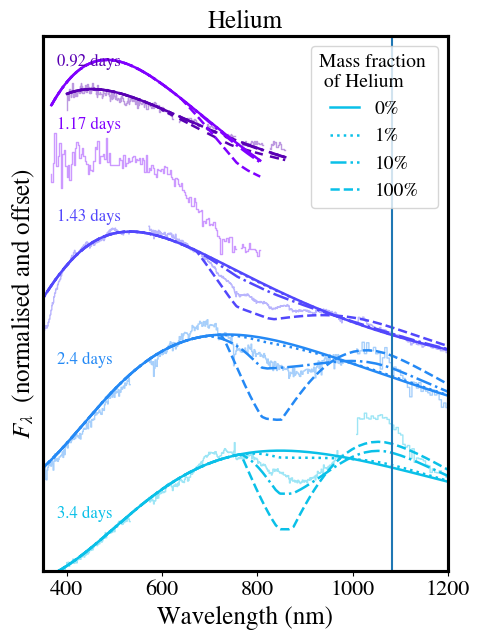

In [22]:
reset_plt(16, 20)

def temp_n(wav,T,N):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return N*a/ ( (wav**5)*(np.exp(b) - 1.0) )


from scipy.optimize import curve_fit
p_ANU,_ = curve_fit(temp_n, wav_ANU[flux_ANU==flux_ANU]*1e-10, flux_ANU[flux_ANU==flux_ANU], p0=[6000, 1e-29*1e16])

p_SALT,_ = curve_fit(temp_n, wl_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)]*1e-10, f_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)], p0=[6000, 1e-29])


from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


#fig, ax2 = plt.subplots( figsize=(11,6), ncols=2 )
#ax = ax2[0]
#axins = ax2[1]

off_sets = np.linspace(-0.2,1.7,5)[::-1]

fig,axi = plt.subplot_mosaic("A", figsize=(5.2,6.8) )
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax = axi['A']
ratio_off_set = np.linspace(0,3.2,7)[::-1]

# ANU
norm = np.max(flux_ANU[flux_ANU==flux_ANU])
ax.plot(wav_ANU/10 , 0.75*flux_ANU/norm+ratio_off_set[2], 
             color=get_darker(0.7, rtot[0]), ds='steps', alpha=0.4, linewidth=1)#, label='0.92 days', alpha=0.4, linewidth=1)

ax.text(3800/10, ratio_off_set[2]+0.85 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '0.92 days', color=get_darker(0.7, rtot[0]), fontsize=fontsize, rotation=rotation)
#ax.plot(    wav_ANU/10, 0.8*temp_n(wav_ANU*1e-10, *p_ANU )/norm+ratio_off_set[2], 
#            color=get_darker(0.7, rtot[0]), linewidth=1, ls='--' )


pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.17, min=0, max=2)
p['vmax'].value = 0.50
p['vphot'].value = 0.31
p['T'].value = 6400
p['occult'].value = 1

p['tau'].max = 32*tau_i/50; 
p['tau'].value = 32*tau_i/50; 
p['ve'].value = 0.06; 
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='dotted', linewidth=lw )


p['tau'].max = 32*tau_i/5; 
p['tau'].value = 32*tau_i/5; 
p['ve'].value = 0.06; 
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='-.', linewidth=lw )

p['tau'].max = 32*tau_i*2; 
p['tau'].value = 32*tau_i*2; 
p['ve'].value = 0.06; 
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='--', linewidth=lw )


p['tau'].value = 0
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='-', linewidth=lw )



# SALT
ax.plot(wl_SALT/10 , f_SALT/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
             color=get_darker(1, rtot[0]), ds='steps', alpha=0.4, linewidth=1)#, label='1.17 days', alpha=0.4, linewidth=1)
#pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
pickle_in = open('../Kilonova/data/Early_Chains/SALT_27dec_params.pkl',"rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.17, min=0, max=2)
p['vphot'].value = 0.31
p['ve'].value = 1
#p['T'].value = 6300
p['occult'].value = 1
p['tau'].value = tau_i

p['vphot'].value = 0.29 #35
p['ve'].value = 1
#p['T'].value = 6000
p['occult'].value = 1
p['tau'].value = tau_i

p['vmax'].value = 0.41
p['vphot'].value = 0.30#p['T'].value = 6300
p['tau'].max = 37.78*tau_i/50; 
p['tau'].value = 37.78*tau_i/50; 
p['ve'].value = 0.06;

ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='dotted' )


p['tau'].max = 37.78*tau_i/5; 
p['tau'].value = 37.78*tau_i/5; 
p['ve'].value = 0.06;

ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='-.' )

p['vphot'].value = 0.30#p['T'].value = 6300
p['tau'].max = 37.78*tau_i*2; 
p['tau'].value = 37.78*tau_i*2; 
p['ve'].value = 0.06;

ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                 color=get_darker(1, rtot[0]), linewidth=lw, ls='--' )


p['tau'].value=0
ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='-' )


p['tau'].max=600
p['tau'].value=600
#ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
#                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
#                 linewidth=lw, ls='-', color='k' )

print(p['tau'].value * np.exp(-p['vphot'].value/p['ve'].value) )


# Days
ax.text(3800/10, ratio_off_set[3]+1.02 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.17 days', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[4]+1.03 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.43 days', color=r[0], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[5]+0.75 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '2.4 days', color=r[1], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[6]+0.4 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '3.4 days', color=r[2], fontsize=fontsize, rotation=rotation)

# X-shooter
for i in [0,1,2]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19300))
    
    if (i == 0): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 50)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        
        pickle_in = open('./data/OB1/OB1_3_peaks_with_gaussian_3.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['tau'].value = tau_i
        
        p1['vmax'].value = 0.38
        p1['vphot'].value = 0.30
        p1['tau'].max = 211*tau_i/50; 
        p1['tau'].value = 211*tau_i/50; 
        p1['ve'].value = 0.057; 
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted' )
        
        p1['tau'].max = 211*tau_i/5; 
        p1['tau'].value = 211*tau_i/5; 
        p1['ve'].value = 0.057; 
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.' )
        
        p1['tau'].max = 211*tau_i*2; 
        p1['tau'].value = 211*tau_i*2; 
        p1['ve'].value = 0.057; 
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-' )
        
        p1['tau'].max = 200
        p1['tau'].value = 200
        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color='k', linewidth=lw, ls='-' )
        print(p1['tau'].value * np.exp(-p1['vphot'].value/p1['ve'].value) )

        
    if (i==1): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB2/OB2_3_peaks_with_gaussian_1.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        
        p1['vmax'].value = 0.36
        p1['vphot'].value = 0.25
        p1['tau'].max = 2698*tau_i/50; 
        p1['tau'].value = 2698*tau_i/50; 
        p1['ve'].value = 0.04;  

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted' )
        
        p1['tau'].max = 2698*tau_i/5; 
        p1['tau'].value = 2698*tau_i/5; 
        p1['ve'].value = 0.04;  

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.' )
        
        p1['vmax'].value = 0.33
        p1['vphot'].value = 0.25
        p1['tau'].max = 2698*tau_i*2; 
        p1['tau'].value = 2698*tau_i*2; 
        p1['ve'].value = 0.04;  

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        # p1['vmax'].value = 0.31
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-' )
        
        p1['tau'].max = 600
        p1['tau'].value = 600
        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color='k', linewidth=lw, ls='-' )
        print(p1['tau'].value * np.exp(-p1['vphot'].value/p1['ve'].value) )

        
        
    if (i==2): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB3/OB3_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        
        
        p1['vmax'].value = 0.293
        p1['vphot'].value = 0.22
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        #p1['vmax'].value = 0.26
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-', label = '0%' )
        

        p1['tau'].max = 11366*tau_i/50; 
        p1['tau'].value = 11366*tau_i/50; 
        p1['ve'].value = 0.0325; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted', label = '1%' )
        
        p1['tau'].max = 11366*tau_i/5; 
        p1['tau'].value = 11366*tau_i/5; 
        p1['ve'].value = 0.0325; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.', label = '10%' )
        
        p1['tau'].max = 11366*tau_i*2; 
        p1['tau'].value = 11366*tau_i*2; 
        p1['ve'].value = 0.0325; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--', label = '100%' )
        
        p1['tau'].max = 1500; 
        p1['tau'].value = 1500; 
        p1['ve'].value = 0.0325; 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color='k', linewidth=lw, ls='-' )
        print(p1['tau'].value * np.exp(-p1['vphot'].value/p1['ve'].value) )
        
    
    
ax.set_xlim(350, 1200)#, 
ax.set_ylim(0.1, 3.15)
ax.set_yticks([])
ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength (nm)', fontsize=18)
#plt.yscale('log')
plt.rcParams['legend.title_fontsize'] = 14
plt.legend(frameon=True, fontsize=14, handlelength=1.5, title='Mass fraction \n of Helium')
plt.title('Helium', fontsize=18)

import matplotlib.ticker as mticker
ax.set_ylabel(r'$F_{\lambda}$  (normalised and offset)', fontsize=18)
plt.tight_layout()

plt.axvline(1083.3, ls='-', alpha=1)

#axins.axvline(1045, color='k', alpha=0.3)
#plt.savefig('Pictures/He_feature_emergence_Comparison_with_Sr.png', dpi=300)
#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.pdf', dpi=300)

ANU 0.8555323497011103
4.04276819945128
Binning image by a factor: 50
1.234416104378286
Binning image by a factor: 80
1.1582724817366257
Binning image by a factor: 80
1.5623901832581288
Binning image by a factor: 80
0.8672991065028677


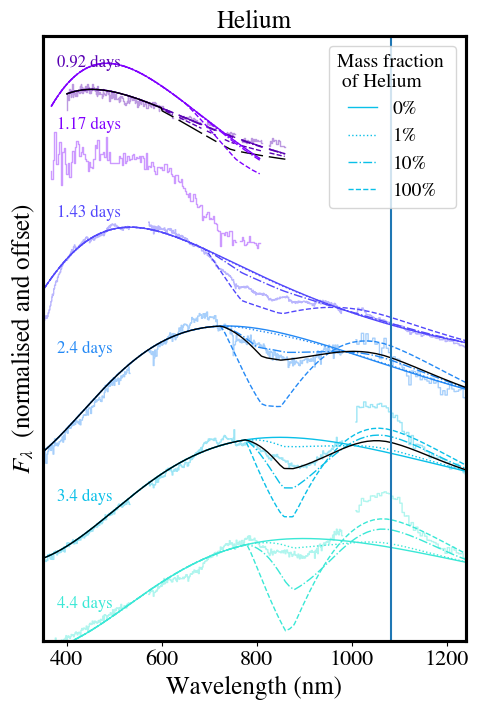

In [23]:
reset_plt(16, 20)
lw = 1

def temp_n(wav,T,N):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return N*a/ ( (wav**5)*(np.exp(b) - 1.0) )


from scipy.optimize import curve_fit
p_ANU,_ = curve_fit(temp_n, wav_ANU[flux_ANU==flux_ANU]*1e-10, flux_ANU[flux_ANU==flux_ANU], p0=[6000, 1e-29*1e16])

p_SALT,_ = curve_fit(temp_n, wl_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)]*1e-10, f_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)], p0=[6000, 1e-29])


from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


#fig, ax2 = plt.subplots( figsize=(11,6), ncols=2 )
#ax = ax2[0]
#axins = ax2[1]

off_sets = np.linspace(-0.2,1.7,5)[::-1]

fig,axi = plt.subplot_mosaic("A", figsize=(5.2,7.5) )
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax = axi['A']
ratio_off_set = np.linspace(0,3.8,8)[::-1]

# ANU
norm = np.max(flux_ANU[flux_ANU==flux_ANU])
ax.plot(wav_ANU/10 , 0.75*flux_ANU/norm+ratio_off_set[2], 
             color=get_darker(0.7, rtot[0]), ds='steps', alpha=0.4, linewidth=1)#, label='0.92 days', alpha=0.4, linewidth=1)

ax.text(3800/10, ratio_off_set[2]+0.85 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '0.92 days', color=get_darker(0.7, rtot[0]), fontsize=fontsize, rotation=rotation)
#ax.plot(    wav_ANU/10, 0.8*temp_n(wav_ANU*1e-10, *p_ANU )/norm+ratio_off_set[2], 
#            color=get_darker(0.7, rtot[0]), linewidth=1, ls='--' )


pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.17, min=0, max=2)
p['vmax'].value = 0.50
p['vphot'].value = 0.31
p['T'].value = 6400
p['occult'].value = 1

p['tau'].max = 32*tau_i/50; 
p['tau'].value = 32*tau_i/50; 
p['ve'].value = 0.06; 
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='dotted', linewidth=lw )


p['tau'].max = 32*tau_i/5; 
p['tau'].value = 32*tau_i/5; 
p['ve'].value = 0.06; 
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='-.', linewidth=lw )

p['tau'].max = 32*tau_i*2; 
p['tau'].value = 32*tau_i*2; 
p['ve'].value = 0.06; 
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='--', linewidth=lw )


p['tau'].value = 0
plt.plot(wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]), ls='-', linewidth=lw )

#p['ve'].value = 0.06; 
p['tau'].max=50*3
p['tau'].value=50*3
ax.plot( wav_ANU/10, residual(p, wav_ANU*1e-10)/(2e-17*norm)+ratio_off_set[2], 
    linewidth=lw, ls='-', color='k' )

print('ANU', p['tau'].value * np.exp(-p['vphot'].value/p['ve'].value) )



# SALT
ax.plot(wl_SALT/10 , f_SALT/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
             color=get_darker(1, rtot[0]), ds='steps', alpha=0.4, linewidth=1)#, label='1.17 days', alpha=0.4, linewidth=1)
#pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
pickle_in = open('../Kilonova/data/Early_Chains/SALT_27dec_params.pkl',"rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.17, min=0, max=2)
p['vmax'].value = 0.40
p['vphot'].value = 0.31
p['ve'].value = 1
#p['T'].value = 6300
p['occult'].value = 1
p['tau'].value = tau_i

p['vmax'].value = 0.40
p['vphot'].value = 0.29 #35
p['ve'].value = 1
#p['T'].value = 6000
p['occult'].value = 1
p['tau'].value = tau_i

p['vmax'].value = 0.40
p['vphot'].value = 0.30#p['T'].value = 6300
p['tau'].max = 37.78*tau_i/50; 
p['tau'].value = 37.78*tau_i/50; 
p['ve'].value = 0.06;

ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='dotted' )


p['tau'].max = 37.78*tau_i/5; 
p['tau'].value = 37.78*tau_i/5; 
p['ve'].value = 0.06;

ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='-.' )

p['vmax'].value = 0.40
p['vphot'].value = 0.30#p['T'].value = 6300
p['tau'].max = 37.78*tau_i*2; 
p['tau'].value = 37.78*tau_i*2; 
p['ve'].value = 0.06;

ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                 color=get_darker(1, rtot[0]), linewidth=lw, ls='--' )


p['tau'].value=0
ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=lw, ls='-' )


p['tau'].max=600
p['tau'].value=600
#ax.plot( np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-1, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
#                 1.65*residual(p, np.linspace( min(wl_SALT[f_SALT==f_SALT])*1e-10, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
#                 linewidth=lw, ls='-', color='k' )

print(p['tau'].value * np.exp(-p['vphot'].value/p['ve'].value) )


# Days
ax.text(3800/10, ratio_off_set[3]+1.02 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.17 days', color=get_darker(1, rtot[0]), fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[4]+1.03 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '1.43 days', color=r[0], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[5]+0.75 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '2.4 days', color=r[1], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[6]+0.4 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '3.4 days', color=r[2], fontsize=fontsize, rotation=rotation)

ax.text(3800/10, ratio_off_set[7]+0.3 #/np.max(flux_LDSS3[flux_LDSS3==flux_LDSS3])+ratio_off_set[0]+0.03
             , '4.4 days', color=r[3], fontsize=fontsize, rotation=rotation)


# X-shooter
for i in [0,1,2,3]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3500)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19300))
    
    if (i == 0): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 50)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        
        pickle_in = open('./data/OB1/OB1_3_peaks_with_gaussian_3.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['tau'].value = tau_i
        
        p1['vmax'].value = 0.36
        p1['vphot'].value = 0.29
        p1['tau'].max = 211*tau_i/50; 
        p1['tau'].value = 211*tau_i/50; 
        p1['ve'].value = 0.057; 
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted' )
        
        p1['tau'].max = 211*tau_i/5; 
        p1['tau'].value = 211*tau_i/5; 
        p1['ve'].value = 0.057; 
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.' )
        
        p1['tau'].max = 211*tau_i*2; 
        p1['tau'].value = 211*tau_i*2; 
        p1['ve'].value = 0.057; 
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-' )
        
        p1['tau'].max = 200
        p1['tau'].value = 200
        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color='k', linewidth=lw, ls='-' )
        print(p1['tau'].value * np.exp(-p1['vphot'].value/p1['ve'].value) )

        
    if (i==1): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB2/OB2_3_peaks_with_gaussian_1.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        
        p1['vmax'].value = 0.33
        p1['vphot'].value = 0.26
        p1['tau'].max = 2698*tau_i/50; 
        p1['tau'].value = 2698*tau_i/50; 
        p1['ve'].value = 0.04;  

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted' )
        
        p1['tau'].max = 2698*tau_i/5; 
        p1['tau'].value = 2698*tau_i/5; 
        p1['ve'].value = 0.04;  

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.' )
        
        p1['vmax'].value = 0.33
        p1['vphot'].value = 0.25
        p1['tau'].max = 2698*tau_i*2; 
        p1['tau'].value = 2698*tau_i*2; 
        p1['ve'].value = 0.04;  

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--' )
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        # p1['vmax'].value = 0.31
        
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-' )
        
        p1['tau'].max = 600
        p1['tau'].value = 600
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='-' )
        print(p1['tau'].value * np.exp(-p1['vphot'].value/p1['ve'].value) )

        
        
    if (i==2): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB3/OB3_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        
        
        p1['vmax'].value = 0.283
        p1['vphot'].value = 0.21
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        #p1['vmax'].value = 0.26
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-', label = '0%' )
        

        p1['tau'].max = 11366*tau_i/50; 
        p1['tau'].value = 11366*tau_i/50; 
        p1['ve'].value = 0.0325; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted', label = '1%' )
        
        p1['tau'].max = 11366*tau_i/5; 
        p1['tau'].value = 11366*tau_i/5; 
        p1['ve'].value = 0.0325; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.', label = '10%' )
        
        p1['tau'].max = 11366*tau_i*2; 
        p1['tau'].value = 11366*tau_i*2; 
        p1['ve'].value = 0.0325; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--', label = '100%' )
        
        p1['tau'].max = 1000; 
        p1['tau'].value = 1000; 
        p1['ve'].value = 0.0325; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='-' )
        print(p1['tau'].value * np.exp(-p1['vphot'].value/p1['ve'].value) )
        
    if (i==3): 
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 80)

        ax.plot(wl50/10, flux50/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color=r[i] , alpha=0.4, ds='steps', linewidth=1)#, label=str(i+1.4)+' days', linewidth=1)
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        
        pickle_in = open('./data/OB4/OB4_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        
        #p1['vmax'].value = 0.283
        #p1['vphot'].value = 0.22
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        #p1['vmax'].value = 0.26
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-' )
        
        
        p1['vmax'].value = 0.28
        p1['vphot'].value = 0.19
        p1['tau'].max = 18145/5; 
        p1['tau'].value = 18145/5; 
        p1['ve'].value = 0.0279; 
        
        #p1['vmax'].value = 0.26
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='-.' )
        
        
        #p1['vmax'].value = 0.283
        #p1['vphot'].value = 0.22
        p1['tau'].max = 18145/50; 
        p1['tau'].value = 18145/50; 
        p1['ve'].value = 0.0279; 
        
        #p1['vmax'].value = 0.26
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='dotted')
        
        p1['tau'].max = 18145*2; 
        p1['tau'].value = 18145*2; 
        p1['ve'].value = 0.0279; 
        
        #p1['vmax'].value = 0.26
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=get_darker(1, r[i]), linewidth=lw, ls='--' )
        
    
    
        p1['tau'].max = 300; 
        p1['tau'].value = 300; 
        p1['ve'].value = 0.0325; 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) )/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color='k', linewidth=lw, ls='-' )
        print(p1['tau'].value * np.exp(-p1['vphot'].value/p1['ve'].value) )
        
        
    
ax.set_xlim(350, 1240)#, 
ax.set_ylim(0.1, 3.75)
ax.set_yticks([])
ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength (nm)', fontsize=18)
#plt.yscale('log')
plt.rcParams['legend.title_fontsize'] = 14
plt.legend(frameon=True, fontsize=14, handlelength=1.5, title='Mass fraction \n of Helium')
plt.title('Helium', fontsize=18)

import matplotlib.ticker as mticker
ax.set_ylabel(r'$F_{\lambda}$  (normalised and offset)', fontsize=18)
plt.tight_layout()

plt.axvline(1083.3, ls='-', alpha=1)

#axins.axvline(1045, color='k', alpha=0.3)
#plt.savefig('Pictures/He_feature_emergence_Comparison_with_Sr_besttau.png', dpi=300)
#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.pdf', dpi=300)

In [ ]:
0.85